<a href="https://colab.research.google.com/github/FarnazMehdipour/predict-data-job-salaries-us/blob/main/Salary_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Understanding the Objective
###The goal is to predict the salary of data related positions based on location, company review and job title


#Import dataset

In [122]:
from google.colab import files

In [123]:
uploaded = files.upload()

Saving df.csv to df (3).csv


#Import Libraries

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import pickle

#Read the data

In [125]:
df_raw = pd.read_csv('df.csv')

# Data Understanding

In [126]:
df_raw.head()

,Job Title,Salary Estimate,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue
0,Senior Data Scientist,$111K-$181K (Glassdoor est.),3.5,Hopper\n3.5,"New York, NY",501 to 1000 employees,2007,Company - Private,Travel Agencies,Travel & Tourism,Unknown / Non-Applicable
1,"Data Scientist, Product Analytics",$111K-$181K (Glassdoor est.),4.5,Noom US\n4.5,"New York, NY",1001 to 5000 employees,2008,Company - Private,"Health, Beauty, & Fitness",Consumer Services,Unknown / Non-Applicable
2,Data Science Manager,$111K-$181K (Glassdoor est.),-1.0,Decode_M,"New York, NY",1 to 50 employees,-1,Unknown,-1,-1,Unknown / Non-Applicable
3,Data Analyst,$111K-$181K (Glassdoor est.),3.4,Sapphire Digital\n3.4,"Lyndhurst, NJ",201 to 500 employees,2019,Company - Private,Internet,Information Technology,Unknown / Non-Applicable
4,"Director, Data Science",$111K-$181K (Glassdoor est.),3.4,United Entertainment Group\n3.4,"New York, NY",51 to 200 employees,2007,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable


A few quick things come to mind looking at the above data:

1. Job titles can be categorized based on the words they contain such as "director", "data analyst", ...
2. Minimum and maximum salaries can be extracted from the salary estimate column and then averaged to create a new average salary column which will be our response variable
3. Company names should not matter much
4. The state where each position is located can be extracted from the location column
5. Because there are too many unknowns in the Revenue column, we will not use that column

#Assess data

In this section, we will check the raw data and get an understanding of what kind of data we are dealing with.



In [127]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5892 entries, 0 to 5891
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          5892 non-null   object 
 1   Salary Estimate    5892 non-null   object 
 2   Rating             5892 non-null   float64
 3   Company Name       5892 non-null   object 
 4   Location           5892 non-null   object 
 5   Size               5892 non-null   object 
 6   Founded            5892 non-null   object 
 7   Type of ownership  5892 non-null   object 
 8   Industry           5892 non-null   object 
 9   Sector             5892 non-null   object 
 10  Revenue            5892 non-null   object 
dtypes: float64(1), object(10)
memory usage: 506.5+ KB


#Clean Data



*  Created minimum and maximum salary columns for the positions and parsed the
corresponding values out of the raw data

*   Created average salary column


* Extracted the state where each position is located. Created a state column

* Title column was created to show the different categories for the posted roles such as data engineer, deep learning, analyst, ...







In [128]:
  # Remove instances without salary estimates
  df = df_raw[df_raw['Salary Estimate'] != '-1']

In [129]:
 # Remove Per Hour salary
df = df[~df['Salary Estimate'].str.contains('Per Hour')]

In [130]:
  # Remove $
  df['Salary Estimate'] = df['Salary Estimate'].apply(lambda x: x.replace('$', ' '))

In [131]:
  # Remove K
df['Salary Estimate'] = df['Salary Estimate'].apply(lambda x: x.replace('K', ' '))

In [132]:
#Split it
df['Salary Estimate'] = df['Salary Estimate'].apply(lambda x: x.split())

In [133]:
df['Min_salary'] = df['Salary Estimate'].apply(lambda x: x[0])
df['Max_salary'] = df['Salary Estimate'].apply(lambda x: x[2])

In [134]:
  # Cast Min_salary and Max_salary to int and get the avrage salary
df['Min_salary'] = df['Min_salary'].apply(lambda x:int(x))
df['Max_salary']=df['Max_salary'].astype(int)
df['Average_salary'] = (df.Min_salary + df.Max_salary)/2

In [135]:
# State: what state is the job in

df['State'] = df['Location'].apply(lambda x: x.split()[-1])
df = df[df.State != 'Kingdom'] # remove United Kingdom


In [136]:
def title_organizer(x):
        """
        This function organizes the job title
        """
        x = x.lower()
        if ('data scientist' in x) or ('data science' in x) :
            return 'data scientist'
        elif 'data engineer' in x:
            return 'data engineer'
        elif 'deep learning' in x:
            return 'deep learning engineer'
        elif 'machine learning' in x:
            return 'machine learning engineer'
        elif 'director' in x:
            return 'director'
        elif 'manager' in x:
            return 'manager'
        elif 'analyst' in x:
            return 'analyst'
        elif 'researcher' in x:
            return 'researcher'
        else:
            return 'other'

In [137]:
df['Job Title'] = df['Job Title'].apply(title_organizer)

In [138]:
df = df[df['Rating']!=-1]

In [139]:
cleaned_df = df[['Job Title', 'Rating', 'Average_salary', 'State']]

In [140]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4891 entries, 0 to 5887
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Job Title       4891 non-null   object 
 1   Rating          4891 non-null   float64
 2   Average_salary  4891 non-null   float64
 3   State           4891 non-null   object 
dtypes: float64(2), object(2)
memory usage: 191.1+ KB


#Exploratory Data Analysis (EDA)

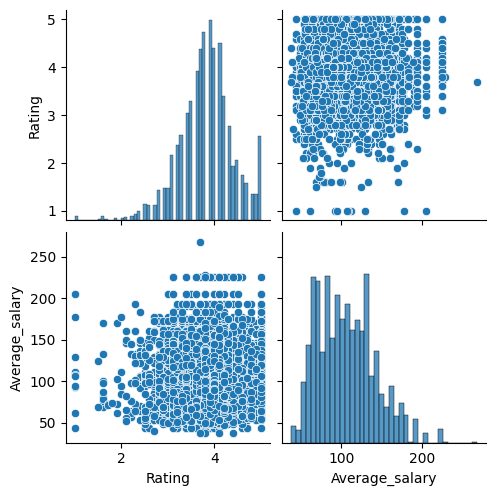

In [141]:
sns.pairplot(cleaned_df)

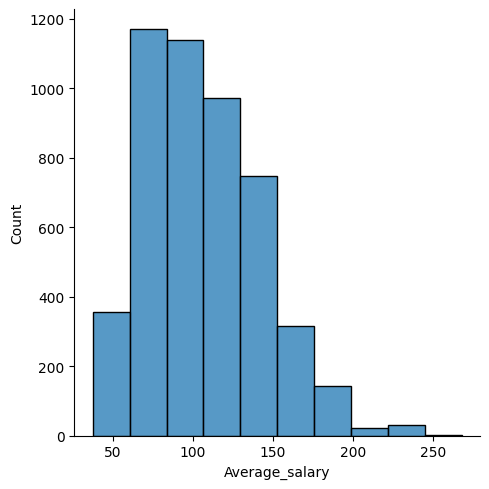

In [142]:
sns.displot(x='Average_salary', data= cleaned_df, bins = 10)

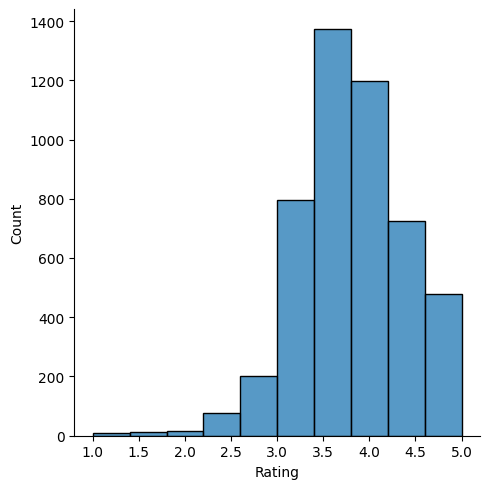

In [143]:
sns.displot(x='Rating', data= cleaned_df, bins = 10)

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'data scientist'),
  Text(1, 0, 'analyst'),
  Text(2, 0, 'researcher'),
  Text(3, 0, 'other'),
  Text(4, 0, 'data engineer'),
  Text(5, 0, 'manager'),
  Text(6, 0, 'machine learning engineer'),
  Text(7, 0, 'director'),
  Text(8, 0, 'deep learning engineer')])

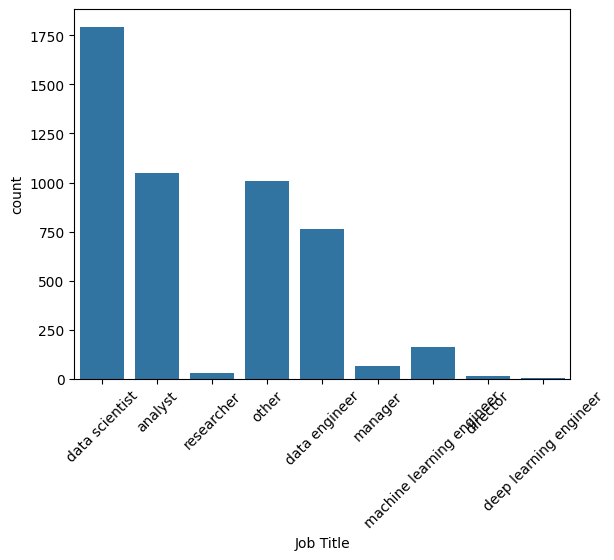

In [144]:
sns.countplot(x='Job Title', data= cleaned_df)
plt.xticks(rotation= 45)

<Axes: xlabel='Rating', ylabel='Average_salary'>

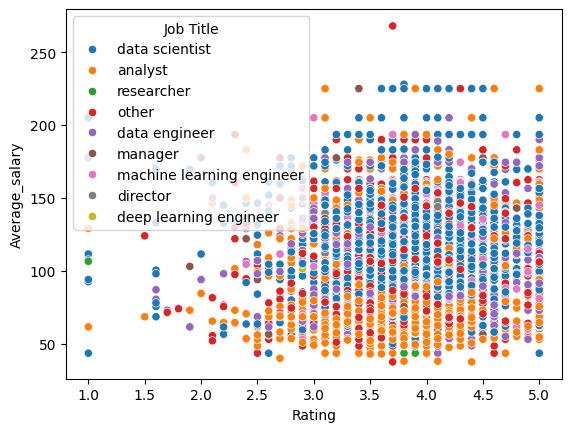

In [145]:
sns.scatterplot(x='Rating', y='Average_salary', data= cleaned_df, hue='Job Title')

# Feature Engineering

In [146]:
preprocessed_df = pd.get_dummies(cleaned_df, columns=['Job Title','State'])

In [147]:
X = preprocessed_df.drop(columns='Average_salary')

In [148]:
y = preprocessed_df['Average_salary']

# Modeling

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 101)

In [150]:
lr = LinearRegression()

In [151]:
lr.fit(X_train,y_train)

LinearRegression()

In [152]:
# print the intercept(b0)
print(lr.intercept_)

87.94145623410465


In [153]:
# print the coefficients(b1, b2, ...)
print(lr.coef_)

[  2.24685151  -6.70425439   1.90902935  10.56034421 -12.57771849
   1.64672839  11.32505628 -11.26747124  -2.41697569   7.52526157
   0.24382921  30.99696713   5.21375267  72.33648121 -14.23644619
 -14.79298466 -17.87794472 -25.32586727 -15.38846081   8.0411967
   2.01815878 -21.03983617 -12.6771238  -19.49992272  -1.8885213
  10.50469582  13.68484898  29.79940539 -10.58240797  -1.93979606
  -1.24432965   0.98017271 -17.32586727]


In [154]:
# Prediction
predictions = lr.predict(X_test)
predictions

array([ 93.02807513, 124.1607428 ,  90.10370397, ...,  83.25542314,
        91.69476086,  91.85811325])

<Axes: xlabel='Average_salary'>

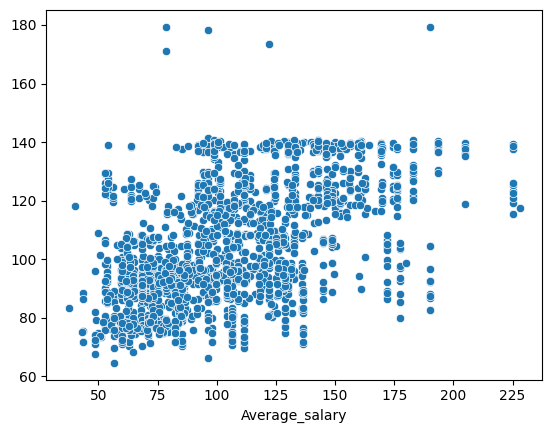

In [155]:
sns.scatterplot(x=y_test, y=predictions)

In [156]:
residual= y_test-predictions

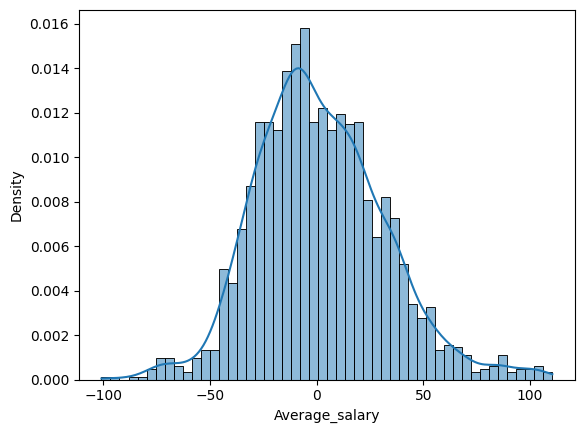

In [157]:
sns.histplot(residual, bins=50, kde=True, stat="density")
plt.xlabel("Average_salary")
plt.ylabel("Density")
plt.show()

In [158]:
print('MAE:', mean_absolute_error(y_test, predictions))


MAE: 23.703329222680196


# Visualizing Linear Regression MAE.


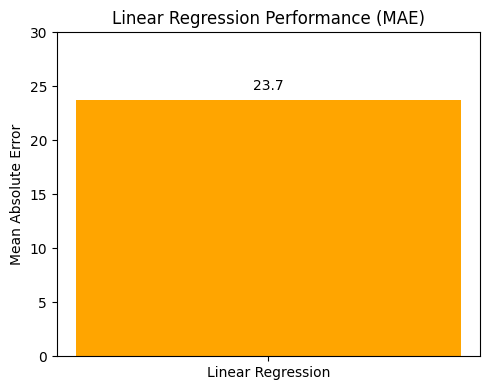

In [159]:
plt.figure(figsize=(5, 4))
plt.bar(['Linear Regression'], [23.7], color='orange')
plt.title('Linear Regression Performance (MAE)')
plt.ylabel('Mean Absolute Error')
plt.ylim(0, max(30, 23.7 + 5))
plt.text(0, 23.7 + 1, '23.7', ha='center')
plt.tight_layout()
plt.show()

# Save the Model

In [160]:
pickle.dump(lr, open('Salary_Estimater.pkl' , 'wb'))